In [1]:
!pip install numpy
!pip install accelerate -U
!pip install transformers[torch]
!pip install pytorch-accelerated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/mtsamples_new.csv'

data = pd.read_csv(file_path)
data.head(5)
data.drop(columns = "Unnamed: 0" , inplace = True)

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

print(data.head())

# Örnek veri temizleme ve ön işleme
data = data.dropna(subset=['transcription', 'medical_specialty'])
data['label'] = data['medical_specialty'].astype('category').cat.codes

# Eğitim ve test veri setlerine ayırma
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['transcription'].values, data['label'].values, test_size=0.2, random_state=42
)


                                       transcription  \
0  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
1  1.  The left ventricular cavity size and wall ...   
2  2-D ECHOCARDIOGRAM,Multiple views of the heart...   
3  DESCRIPTION:,1.  Normal cardiac chambers size....   
4  2-D STUDY,1. Mild aortic stenosis, widely calc...   

            medical_specialty  
0  Cardiovascular / Pulmonary  
1  Cardiovascular / Pulmonary  
2  Cardiovascular / Pulmonary  
3  Cardiovascular / Pulmonary  
4  Cardiovascular / Pulmonary  


In [4]:
from torch.utils.data import Dataset

class MedicalTranscriptionsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Tokenizer ve modeli yükleme
tokenizer = BertTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = BertForSequenceClassification.from_pretrained("medicalai/ClinicalBERT", num_labels=len(data['label'].unique()))

# Veriyi tokenleştirme
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

train_dataset = MedicalTranscriptionsDataset(train_encodings, train_labels)
test_dataset = MedicalTranscriptionsDataset(test_encodings, test_labels)

# Eğitim argümanlarını belirleme
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer'ı tanımlama
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Modeli eğitme
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNo

Step,Training Loss
10,2.527100
20,2.410700
30,2.345400
40,2.303000
50,2.305900
60,2.322300
70,2.389200
80,2.410600
90,2.308300
100,2.395500


TrainOutput(global_step=1864, training_loss=2.1977467137856546, metrics={'train_runtime': 1568.9633, 'train_samples_per_second': 9.479, 'train_steps_per_second': 1.188, 'total_flos': 3913338946682880.0, 'train_loss': 2.1977467137856546, 'epoch': 8.0})

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3913978494623656
Precision: 0.30751928857715527
Recall: 0.3913978494623656
F1 Score: 0.33302197003836176


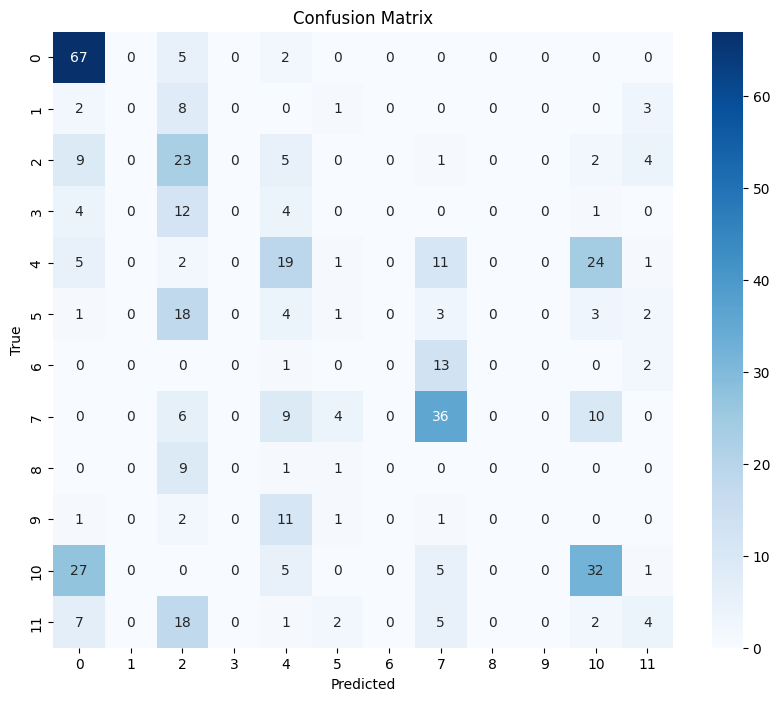

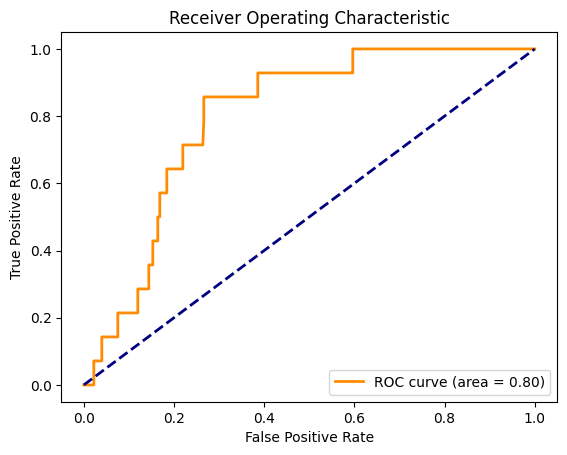

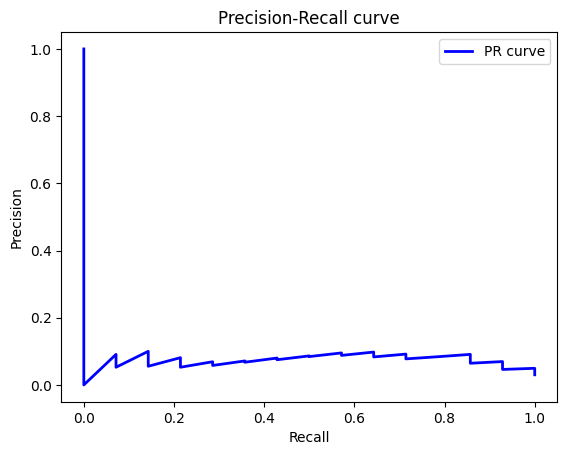

In [8]:
# Tahminleri alma
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_labels

# Değerlendirme metriklerini hesaplama
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
cm = confusion_matrix(true_labels, pred_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Karışıklık Matrisi Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Eğrisi ve AUC Skoru
fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# PR Eğrisi
precision_curve, recall_curve, _ = precision_recall_curve(true_labels, predictions.predictions[:, 1], pos_label=1)

plt.figure()
plt.plot(recall_curve, precision_curve, lw=2, color="b", label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc="upper right")
plt.show()
